<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:09:30] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


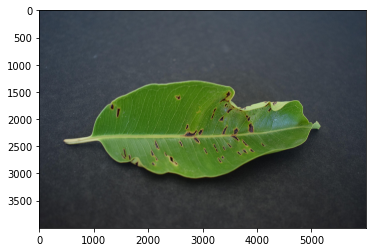

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

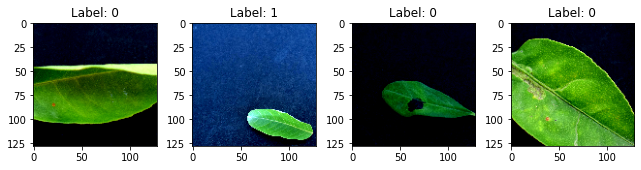

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:09:36] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:09:38] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2006569069552615 samples/sec                   batch loss = 1.2441848516464233 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2503298497149251 samples/sec                   batch loss = 1.108091115951538 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.256109745607547 samples/sec                   batch loss = 0.9907246232032776 | accuracy = 0.5833333333333334


Epoch[1] Batch[20] Speed: 1.256577322775034 samples/sec                   batch loss = 0.4671512842178345 | accuracy = 0.5875


Epoch[1] Batch[25] Speed: 1.2577223321891509 samples/sec                   batch loss = 0.37472066283226013 | accuracy = 0.59


Epoch[1] Batch[30] Speed: 1.2653878748183438 samples/sec                   batch loss = 0.26495954394340515 | accuracy = 0.5916666666666667


Epoch[1] Batch[35] Speed: 1.2657551365329862 samples/sec                   batch loss = 0.384493350982666 | accuracy = 0.6142857142857143


Epoch[1] Batch[40] Speed: 1.2646774416772375 samples/sec                   batch loss = 0.6848940849304199 | accuracy = 0.6125


Epoch[1] Batch[45] Speed: 1.2680694739238478 samples/sec                   batch loss = 1.3398594856262207 | accuracy = 0.6277777777777778


Epoch[1] Batch[50] Speed: 1.263900580360728 samples/sec                   batch loss = 0.3564773499965668 | accuracy = 0.63


Epoch[1] Batch[55] Speed: 1.2604817281713026 samples/sec                   batch loss = 0.6435347199440002 | accuracy = 0.6318181818181818


Epoch[1] Batch[60] Speed: 1.2603315507475052 samples/sec                   batch loss = 0.5387080907821655 | accuracy = 0.6375


Epoch[1] Batch[65] Speed: 1.2652885302622696 samples/sec                   batch loss = 0.29977962374687195 | accuracy = 0.65


Epoch[1] Batch[70] Speed: 1.2653063748688667 samples/sec                   batch loss = 0.48327362537384033 | accuracy = 0.6357142857142857


Epoch[1] Batch[75] Speed: 1.2593412387248488 samples/sec                   batch loss = 0.39337942004203796 | accuracy = 0.6366666666666667


Epoch[1] Batch[80] Speed: 1.2582951950872443 samples/sec                   batch loss = 0.7559278011322021 | accuracy = 0.634375


Epoch[1] Batch[85] Speed: 1.2589496306568335 samples/sec                   batch loss = 0.6499094367027283 | accuracy = 0.6264705882352941


Epoch[1] Batch[90] Speed: 1.2607175770487882 samples/sec                   batch loss = 0.7271673679351807 | accuracy = 0.6305555555555555


Epoch[1] Batch[95] Speed: 1.266014266831955 samples/sec                   batch loss = 0.5309189558029175 | accuracy = 0.631578947368421


Epoch[1] Batch[100] Speed: 1.2649861073484892 samples/sec                   batch loss = 0.6476377844810486 | accuracy = 0.64


Epoch[1] Batch[105] Speed: 1.2520005856573937 samples/sec                   batch loss = 0.6966097950935364 | accuracy = 0.6404761904761904


Epoch[1] Batch[110] Speed: 1.251776765943515 samples/sec                   batch loss = 0.48688656091690063 | accuracy = 0.6431818181818182


Epoch[1] Batch[115] Speed: 1.2572618168874234 samples/sec                   batch loss = 0.5495589375495911 | accuracy = 0.6369565217391304


Epoch[1] Batch[120] Speed: 1.2559535564430704 samples/sec                   batch loss = 0.49134308099746704 | accuracy = 0.63125


Epoch[1] Batch[125] Speed: 1.2631358945668163 samples/sec                   batch loss = 0.4407605528831482 | accuracy = 0.632


Epoch[1] Batch[130] Speed: 1.2576514327161772 samples/sec                   batch loss = 0.6179872751235962 | accuracy = 0.6307692307692307


Epoch[1] Batch[135] Speed: 1.2654171753751193 samples/sec                   batch loss = 0.769601583480835 | accuracy = 0.6296296296296297


Epoch[1] Batch[140] Speed: 1.270261381098645 samples/sec                   batch loss = 0.661605179309845 | accuracy = 0.6357142857142857


Epoch[1] Batch[145] Speed: 1.2697794341974438 samples/sec                   batch loss = 0.9005840420722961 | accuracy = 0.6310344827586207


Epoch[1] Batch[150] Speed: 1.2673193613493647 samples/sec                   batch loss = 0.3381962776184082 | accuracy = 0.635


Epoch[1] Batch[155] Speed: 1.2702206999926031 samples/sec                   batch loss = 0.8834000825881958 | accuracy = 0.632258064516129


Epoch[1] Batch[160] Speed: 1.2650248323054998 samples/sec                   batch loss = 1.0121345520019531 | accuracy = 0.6328125


Epoch[1] Batch[165] Speed: 1.25938945057037 samples/sec                   batch loss = 0.986483097076416 | accuracy = 0.6303030303030303


Epoch[1] Batch[170] Speed: 1.2675254077889593 samples/sec                   batch loss = 0.4844917058944702 | accuracy = 0.6279411764705882


Epoch[1] Batch[175] Speed: 1.27121009505274 samples/sec                   batch loss = 0.500385582447052 | accuracy = 0.6342857142857142


Epoch[1] Batch[180] Speed: 1.269741378573093 samples/sec                   batch loss = 0.9033785462379456 | accuracy = 0.6347222222222222


Epoch[1] Batch[185] Speed: 1.2654177480379565 samples/sec                   batch loss = 0.8881097435951233 | accuracy = 0.6324324324324324


Epoch[1] Batch[190] Speed: 1.2646843056334074 samples/sec                   batch loss = 0.9849227070808411 | accuracy = 0.6289473684210526


Epoch[1] Batch[195] Speed: 1.2648276077319272 samples/sec                   batch loss = 0.5513290166854858 | accuracy = 0.632051282051282


Epoch[1] Batch[200] Speed: 1.265328991483858 samples/sec                   batch loss = 0.8015381097793579 | accuracy = 0.63625


Epoch[1] Batch[205] Speed: 1.2585124779564367 samples/sec                   batch loss = 0.44321292638778687 | accuracy = 0.6402439024390244


Epoch[1] Batch[210] Speed: 1.2568808226069321 samples/sec                   batch loss = 1.0993695259094238 | accuracy = 0.6416666666666667


Epoch[1] Batch[215] Speed: 1.2642890822277697 samples/sec                   batch loss = 1.491968035697937 | accuracy = 0.6453488372093024


Epoch[1] Batch[220] Speed: 1.2594872090537175 samples/sec                   batch loss = 0.5969604253768921 | accuracy = 0.6431818181818182


Epoch[1] Batch[225] Speed: 1.2614233773170471 samples/sec                   batch loss = 0.22467738389968872 | accuracy = 0.6411111111111111


Epoch[1] Batch[230] Speed: 1.2705898105416473 samples/sec                   batch loss = 0.5212068557739258 | accuracy = 0.6423913043478261


Epoch[1] Batch[235] Speed: 1.2597224021141018 samples/sec                   batch loss = 0.44450563192367554 | accuracy = 0.6436170212765957


Epoch[1] Batch[240] Speed: 1.2643295748329233 samples/sec                   batch loss = 0.8831793665885925 | accuracy = 0.6427083333333333


Epoch[1] Batch[245] Speed: 1.2631939081964922 samples/sec                   batch loss = 0.33920133113861084 | accuracy = 0.6459183673469387


Epoch[1] Batch[250] Speed: 1.2608519272215908 samples/sec                   batch loss = 0.761344850063324 | accuracy = 0.646


Epoch[1] Batch[255] Speed: 1.2668650895530773 samples/sec                   batch loss = 0.2632474899291992 | accuracy = 0.6480392156862745


Epoch[1] Batch[260] Speed: 1.2652646746225653 samples/sec                   batch loss = 0.6950047612190247 | accuracy = 0.6509615384615385


Epoch[1] Batch[265] Speed: 1.267242589800509 samples/sec                   batch loss = 0.6388912796974182 | accuracy = 0.6528301886792452


Epoch[1] Batch[270] Speed: 1.2699948374242835 samples/sec                   batch loss = 0.4369637668132782 | accuracy = 0.6555555555555556


Epoch[1] Batch[275] Speed: 1.265677122130046 samples/sec                   batch loss = 0.7265753149986267 | accuracy = 0.6554545454545454


Epoch[1] Batch[280] Speed: 1.2687919761530377 samples/sec                   batch loss = 0.5038005113601685 | accuracy = 0.65625


Epoch[1] Batch[285] Speed: 1.2698876553325398 samples/sec                   batch loss = 0.9242076277732849 | accuracy = 0.656140350877193


Epoch[1] Batch[290] Speed: 1.2695400868939324 samples/sec                   batch loss = 1.015326976776123 | accuracy = 0.656896551724138


Epoch[1] Batch[295] Speed: 1.2671014195250285 samples/sec                   batch loss = 0.23839089274406433 | accuracy = 0.6610169491525424


Epoch[1] Batch[300] Speed: 1.2570221732649804 samples/sec                   batch loss = 0.4733103811740875 | accuracy = 0.6633333333333333


Epoch[1] Batch[305] Speed: 1.2591484282499525 samples/sec                   batch loss = 0.33201301097869873 | accuracy = 0.660655737704918


Epoch[1] Batch[310] Speed: 1.2567142749278206 samples/sec                   batch loss = 0.7977473139762878 | accuracy = 0.6588709677419354


Epoch[1] Batch[315] Speed: 1.2600462554268712 samples/sec                   batch loss = 0.4204229712486267 | accuracy = 0.6603174603174603


Epoch[1] Batch[320] Speed: 1.259999318075549 samples/sec                   batch loss = 0.7793628573417664 | accuracy = 0.659375


Epoch[1] Batch[325] Speed: 1.2692363966042974 samples/sec                   batch loss = 0.46547964215278625 | accuracy = 0.6615384615384615


Epoch[1] Batch[330] Speed: 1.2667016237687154 samples/sec                   batch loss = 0.25847136974334717 | accuracy = 0.6636363636363637


Epoch[1] Batch[335] Speed: 1.2621077507328284 samples/sec                   batch loss = 0.28067898750305176 | accuracy = 0.6649253731343283


Epoch[1] Batch[340] Speed: 1.2684588170513087 samples/sec                   batch loss = 0.5806289911270142 | accuracy = 0.6669117647058823


Epoch[1] Batch[345] Speed: 1.263655544150473 samples/sec                   batch loss = 0.5842671990394592 | accuracy = 0.6695652173913044


Epoch[1] Batch[350] Speed: 1.2578336001362704 samples/sec                   batch loss = 0.8285561800003052 | accuracy = 0.67


Epoch[1] Batch[355] Speed: 1.2629884117769499 samples/sec                   batch loss = 0.449617862701416 | accuracy = 0.671830985915493


Epoch[1] Batch[360] Speed: 1.2624601907263309 samples/sec                   batch loss = 0.5142548084259033 | accuracy = 0.6722222222222223


Epoch[1] Batch[365] Speed: 1.2707925903376316 samples/sec                   batch loss = 0.3754618167877197 | accuracy = 0.6732876712328767


Epoch[1] Batch[370] Speed: 1.2619076380043748 samples/sec                   batch loss = 0.36964717507362366 | accuracy = 0.675


Epoch[1] Batch[375] Speed: 1.2637843333888998 samples/sec                   batch loss = 0.261130690574646 | accuracy = 0.6766666666666666


Epoch[1] Batch[380] Speed: 1.2625496853976197 samples/sec                   batch loss = 0.6061576008796692 | accuracy = 0.6776315789473685


Epoch[1] Batch[385] Speed: 1.2623375599314823 samples/sec                   batch loss = 0.2284572571516037 | accuracy = 0.6779220779220779


Epoch[1] Batch[390] Speed: 1.2678804971702227 samples/sec                   batch loss = 0.42802420258522034 | accuracy = 0.6794871794871795


Epoch[1] Batch[395] Speed: 1.2662046944442202 samples/sec                   batch loss = 0.44899052381515503 | accuracy = 0.6791139240506329


Epoch[1] Batch[400] Speed: 1.2613259818454698 samples/sec                   batch loss = 0.5914103388786316 | accuracy = 0.68


Epoch[1] Batch[405] Speed: 1.2669296649003985 samples/sec                   batch loss = 0.3748389482498169 | accuracy = 0.6808641975308642


Epoch[1] Batch[410] Speed: 1.269263571061163 samples/sec                   batch loss = 0.9101101756095886 | accuracy = 0.6792682926829269


Epoch[1] Batch[415] Speed: 1.2666885215503398 samples/sec                   batch loss = 0.9261534214019775 | accuracy = 0.6789156626506024


Epoch[1] Batch[420] Speed: 1.267905313926276 samples/sec                   batch loss = 0.41968539357185364 | accuracy = 0.6815476190476191


Epoch[1] Batch[425] Speed: 1.2606815783406917 samples/sec                   batch loss = 0.8925468921661377 | accuracy = 0.6811764705882353


Epoch[1] Batch[430] Speed: 1.2669036426352254 samples/sec                   batch loss = 0.7012016177177429 | accuracy = 0.6802325581395349


Epoch[1] Batch[435] Speed: 1.2585610040152357 samples/sec                   batch loss = 1.134153127670288 | accuracy = 0.6793103448275862


Epoch[1] Batch[440] Speed: 1.2608068248172166 samples/sec                   batch loss = 0.6939036846160889 | accuracy = 0.6778409090909091


Epoch[1] Batch[445] Speed: 1.2618790692105095 samples/sec                   batch loss = 0.5121180415153503 | accuracy = 0.6775280898876405


Epoch[1] Batch[450] Speed: 1.2647093787731323 samples/sec                   batch loss = 0.36396992206573486 | accuracy = 0.6788888888888889


Epoch[1] Batch[455] Speed: 1.2628592143501474 samples/sec                   batch loss = 1.3331106901168823 | accuracy = 0.6807692307692308


Epoch[1] Batch[460] Speed: 1.265852453165873 samples/sec                   batch loss = 0.6470292806625366 | accuracy = 0.678804347826087


Epoch[1] Batch[465] Speed: 1.2663152700242724 samples/sec                   batch loss = 0.5602359175682068 | accuracy = 0.678494623655914


Epoch[1] Batch[470] Speed: 1.2657330776299252 samples/sec                   batch loss = 0.6388850212097168 | accuracy = 0.6771276595744681


Epoch[1] Batch[475] Speed: 1.2712709719691277 samples/sec                   batch loss = 0.4846193492412567 | accuracy = 0.6763157894736842


Epoch[1] Batch[480] Speed: 1.2649951683944232 samples/sec                   batch loss = 1.2669721841812134 | accuracy = 0.6760416666666667


Epoch[1] Batch[485] Speed: 1.2643535857908292 samples/sec                   batch loss = 0.506534218788147 | accuracy = 0.6757731958762887


Epoch[1] Batch[490] Speed: 1.2651459823328262 samples/sec                   batch loss = 0.48632732033729553 | accuracy = 0.6760204081632653


Epoch[1] Batch[495] Speed: 1.25717504856251 samples/sec                   batch loss = 0.49642783403396606 | accuracy = 0.6737373737373737


Epoch[1] Batch[500] Speed: 1.2716558258588417 samples/sec                   batch loss = 0.6997726559638977 | accuracy = 0.6745


Epoch[1] Batch[505] Speed: 1.2685665254276377 samples/sec                   batch loss = 0.19193360209465027 | accuracy = 0.6762376237623763


Epoch[1] Batch[510] Speed: 1.2736859877973086 samples/sec                   batch loss = 0.3790564239025116 | accuracy = 0.6769607843137255


Epoch[1] Batch[515] Speed: 1.2709208167513646 samples/sec                   batch loss = 0.6025574207305908 | accuracy = 0.6766990291262136


Epoch[1] Batch[520] Speed: 1.2673756536320606 samples/sec                   batch loss = 0.6023783683776855 | accuracy = 0.6764423076923077


Epoch[1] Batch[525] Speed: 1.2694575709491436 samples/sec                   batch loss = 0.35106945037841797 | accuracy = 0.6771428571428572


Epoch[1] Batch[530] Speed: 1.2609698151297895 samples/sec                   batch loss = 0.6267471313476562 | accuracy = 0.6759433962264151


Epoch[1] Batch[535] Speed: 1.2512900756156708 samples/sec                   batch loss = 0.3459334373474121 | accuracy = 0.6757009345794392


Epoch[1] Batch[540] Speed: 1.259528434781486 samples/sec                   batch loss = 0.574047863483429 | accuracy = 0.6763888888888889


Epoch[1] Batch[545] Speed: 1.265090174122788 samples/sec                   batch loss = 0.38202744722366333 | accuracy = 0.6770642201834862


Epoch[1] Batch[550] Speed: 1.2615354908217462 samples/sec                   batch loss = 1.1511787176132202 | accuracy = 0.675


Epoch[1] Batch[555] Speed: 1.259444567849122 samples/sec                   batch loss = 0.6135237216949463 | accuracy = 0.6761261261261261


Epoch[1] Batch[560] Speed: 1.265591575162589 samples/sec                   batch loss = 0.4980006814002991 | accuracy = 0.6754464285714286


Epoch[1] Batch[565] Speed: 1.2654253835919802 samples/sec                   batch loss = 0.42218002676963806 | accuracy = 0.6774336283185841


Epoch[1] Batch[570] Speed: 1.2700963646807986 samples/sec                   batch loss = 0.6971160769462585 | accuracy = 0.6776315789473685


Epoch[1] Batch[575] Speed: 1.2642947986736115 samples/sec                   batch loss = 0.29490408301353455 | accuracy = 0.6769565217391305


Epoch[1] Batch[580] Speed: 1.2603460366695352 samples/sec                   batch loss = 0.3559454083442688 | accuracy = 0.6771551724137931


Epoch[1] Batch[585] Speed: 1.2624875508079418 samples/sec                   batch loss = 0.3979247212409973 | accuracy = 0.6786324786324787


Epoch[1] Batch[590] Speed: 1.263716937076414 samples/sec                   batch loss = 0.7292444705963135 | accuracy = 0.6788135593220339


Epoch[1] Batch[595] Speed: 1.2712007521180597 samples/sec                   batch loss = 0.5159085392951965 | accuracy = 0.6794117647058824


Epoch[1] Batch[600] Speed: 1.2672726463812494 samples/sec                   batch loss = 0.5900561809539795 | accuracy = 0.67875


Epoch[1] Batch[605] Speed: 1.2688297829699022 samples/sec                   batch loss = 0.19201448559761047 | accuracy = 0.6797520661157025


Epoch[1] Batch[610] Speed: 1.2662051722573844 samples/sec                   batch loss = 0.304127961397171 | accuracy = 0.6795081967213115


Epoch[1] Batch[615] Speed: 1.2668639416064567 samples/sec                   batch loss = 0.708217978477478 | accuracy = 0.6804878048780488


Epoch[1] Batch[620] Speed: 1.2693820768161097 samples/sec                   batch loss = 0.4241350591182709 | accuracy = 0.6814516129032258


Epoch[1] Batch[625] Speed: 1.2608454838234036 samples/sec                   batch loss = 0.18663650751113892 | accuracy = 0.6828


Epoch[1] Batch[630] Speed: 1.264261262929273 samples/sec                   batch loss = 0.4889031946659088 | accuracy = 0.6837301587301587


Epoch[1] Batch[635] Speed: 1.261680547079661 samples/sec                   batch loss = 0.19510868191719055 | accuracy = 0.684251968503937


Epoch[1] Batch[640] Speed: 1.266709370463288 samples/sec                   batch loss = 0.41160106658935547 | accuracy = 0.686328125


Epoch[1] Batch[645] Speed: 1.2668938845613784 samples/sec                   batch loss = 0.31845054030418396 | accuracy = 0.6864341085271318


Epoch[1] Batch[650] Speed: 1.2664347554076982 samples/sec                   batch loss = 3.064821481704712 | accuracy = 0.686923076923077


Epoch[1] Batch[655] Speed: 1.2719033963257422 samples/sec                   batch loss = 0.43748411536216736 | accuracy = 0.6885496183206107


Epoch[1] Batch[660] Speed: 1.2688796837408969 samples/sec                   batch loss = 0.6337767839431763 | accuracy = 0.6890151515151515


Epoch[1] Batch[665] Speed: 1.2623801123027543 samples/sec                   batch loss = 0.24279607832431793 | accuracy = 0.6890977443609022


Epoch[1] Batch[670] Speed: 1.261374061274458 samples/sec                   batch loss = 0.881827712059021 | accuracy = 0.6888059701492537


Epoch[1] Batch[675] Speed: 1.263445140174184 samples/sec                   batch loss = 0.3923938274383545 | accuracy = 0.6888888888888889


Epoch[1] Batch[680] Speed: 1.2626144866985423 samples/sec                   batch loss = 0.23250217735767365 | accuracy = 0.6900735294117647


Epoch[1] Batch[685] Speed: 1.261805707436924 samples/sec                   batch loss = 0.4892524480819702 | accuracy = 0.6908759124087591


Epoch[1] Batch[690] Speed: 1.2662008719518874 samples/sec                   batch loss = 0.23812811076641083 | accuracy = 0.6909420289855073


Epoch[1] Batch[695] Speed: 1.262717688424715 samples/sec                   batch loss = 0.3128799498081207 | accuracy = 0.6906474820143885


Epoch[1] Batch[700] Speed: 1.264387317010233 samples/sec                   batch loss = 0.28013765811920166 | accuracy = 0.6917857142857143


Epoch[1] Batch[705] Speed: 1.2696503810642676 samples/sec                   batch loss = 0.6878588795661926 | accuracy = 0.6911347517730496


Epoch[1] Batch[710] Speed: 1.2597095384620929 samples/sec                   batch loss = 0.5994090437889099 | accuracy = 0.6901408450704225


Epoch[1] Batch[715] Speed: 1.2566381239638786 samples/sec                   batch loss = 0.3355056643486023 | accuracy = 0.6902097902097902


Epoch[1] Batch[720] Speed: 1.2541855296049236 samples/sec                   batch loss = 0.36268553137779236 | accuracy = 0.6913194444444445


Epoch[1] Batch[725] Speed: 1.2652337590518252 samples/sec                   batch loss = 0.7630012631416321 | accuracy = 0.6910344827586207


Epoch[1] Batch[730] Speed: 1.2628434348718542 samples/sec                   batch loss = 0.4369004964828491 | accuracy = 0.6914383561643835


Epoch[1] Batch[735] Speed: 1.2702403189241112 samples/sec                   batch loss = 0.7269763946533203 | accuracy = 0.6914965986394558


Epoch[1] Batch[740] Speed: 1.2618616058672614 samples/sec                   batch loss = 0.44502806663513184 | accuracy = 0.6918918918918919


Epoch[1] Batch[745] Speed: 1.2681119343616722 samples/sec                   batch loss = 0.33425548672676086 | accuracy = 0.6926174496644295


Epoch[1] Batch[750] Speed: 1.263912291929319 samples/sec                   batch loss = 0.8508500456809998 | accuracy = 0.6926666666666667


Epoch[1] Batch[755] Speed: 1.2729314390669972 samples/sec                   batch loss = 0.3064568042755127 | accuracy = 0.6940397350993377


Epoch[1] Batch[760] Speed: 1.2645844042879388 samples/sec                   batch loss = 0.945365846157074 | accuracy = 0.694078947368421


Epoch[1] Batch[765] Speed: 1.2608133625708207 samples/sec                   batch loss = 0.6150826811790466 | accuracy = 0.6947712418300653


Epoch[1] Batch[770] Speed: 1.263694092500132 samples/sec                   batch loss = 0.6753997206687927 | accuracy = 0.6948051948051948


Epoch[1] Batch[775] Speed: 1.2540667507434455 samples/sec                   batch loss = 0.5118718147277832 | accuracy = 0.6958064516129032


Epoch[1] Batch[780] Speed: 1.2644488763605444 samples/sec                   batch loss = 0.7533869743347168 | accuracy = 0.6955128205128205


Epoch[1] Batch[785] Speed: 1.2552007075778373 samples/sec                   batch loss = 0.13189640641212463 | accuracy = 0.695859872611465


[Epoch 1] training: accuracy=0.6960659898477157
[Epoch 1] time cost: 650.498871088028
[Epoch 1] validation: validation accuracy=0.7533333333333333


Epoch[2] Batch[5] Speed: 1.2628945770227054 samples/sec                   batch loss = 0.5561026334762573 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.2633181323463258 samples/sec                   batch loss = 0.6637809872627258 | accuracy = 0.675


Epoch[2] Batch[15] Speed: 1.2661859644523075 samples/sec                   batch loss = 0.4521523416042328 | accuracy = 0.7


Epoch[2] Batch[20] Speed: 1.2698510349262442 samples/sec                   batch loss = 0.5530475378036499 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2597205103840945 samples/sec                   batch loss = 0.5340991616249084 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.259808387240754 samples/sec                   batch loss = 1.020678162574768 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.2609505762891582 samples/sec                   batch loss = 0.5364211201667786 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.2643845536505667 samples/sec                   batch loss = 0.35183268785476685 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.2768956332208088 samples/sec                   batch loss = 0.957488477230072 | accuracy = 0.7388888888888889


Epoch[2] Batch[50] Speed: 1.2682838179591274 samples/sec                   batch loss = 0.3940861225128174 | accuracy = 0.73


Epoch[2] Batch[55] Speed: 1.2696459612428854 samples/sec                   batch loss = 0.5579800605773926 | accuracy = 0.7318181818181818


Epoch[2] Batch[60] Speed: 1.2701651163109375 samples/sec                   batch loss = 0.24194101989269257 | accuracy = 0.7291666666666666


Epoch[2] Batch[65] Speed: 1.2678910369865437 samples/sec                   batch loss = 0.27864086627960205 | accuracy = 0.7384615384615385


Epoch[2] Batch[70] Speed: 1.2615269535595326 samples/sec                   batch loss = 0.27323776483535767 | accuracy = 0.7464285714285714


Epoch[2] Batch[75] Speed: 1.2611398627219164 samples/sec                   batch loss = 0.6869263052940369 | accuracy = 0.73


Epoch[2] Batch[80] Speed: 1.2647814576695677 samples/sec                   batch loss = 0.4519665837287903 | accuracy = 0.734375


Epoch[2] Batch[85] Speed: 1.2636373653744923 samples/sec                   batch loss = 0.0504603236913681 | accuracy = 0.7352941176470589


Epoch[2] Batch[90] Speed: 1.2704559747653754 samples/sec                   batch loss = 0.23312772810459137 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2695848555618936 samples/sec                   batch loss = 0.3678206503391266 | accuracy = 0.7447368421052631


Epoch[2] Batch[100] Speed: 1.2659713735842706 samples/sec                   batch loss = 0.7115784287452698 | accuracy = 0.7425


Epoch[2] Batch[105] Speed: 1.2668728382471817 samples/sec                   batch loss = 0.6839185953140259 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.2602909351340505 samples/sec                   batch loss = 0.6903418898582458 | accuracy = 0.7454545454545455


Epoch[2] Batch[115] Speed: 1.2651642999467834 samples/sec                   batch loss = 0.8170443177223206 | accuracy = 0.741304347826087


Epoch[2] Batch[120] Speed: 1.2673320936899655 samples/sec                   batch loss = 0.9428040981292725 | accuracy = 0.7354166666666667


Epoch[2] Batch[125] Speed: 1.2645495187959974 samples/sec                   batch loss = 0.35453227162361145 | accuracy = 0.73


Epoch[2] Batch[130] Speed: 1.268913177036484 samples/sec                   batch loss = 0.6225778460502625 | accuracy = 0.7307692307692307


Epoch[2] Batch[135] Speed: 1.269203846401456 samples/sec                   batch loss = 0.7676516771316528 | accuracy = 0.7351851851851852


Epoch[2] Batch[140] Speed: 1.2574470757780303 samples/sec                   batch loss = 0.6025341153144836 | accuracy = 0.7303571428571428


Epoch[2] Batch[145] Speed: 1.2540223199196456 samples/sec                   batch loss = 0.20549413561820984 | accuracy = 0.7327586206896551


Epoch[2] Batch[150] Speed: 1.26041799781907 samples/sec                   batch loss = 0.4080263674259186 | accuracy = 0.735


Epoch[2] Batch[155] Speed: 1.265335862514359 samples/sec                   batch loss = 0.4058510363101959 | accuracy = 0.7370967741935484


Epoch[2] Batch[160] Speed: 1.2646408351693015 samples/sec                   batch loss = 0.3208136260509491 | accuracy = 0.7390625


Epoch[2] Batch[165] Speed: 1.2572513588323937 samples/sec                   batch loss = 0.629252016544342 | accuracy = 0.7363636363636363


Epoch[2] Batch[170] Speed: 1.2584629172650608 samples/sec                   batch loss = 1.2820028066635132 | accuracy = 0.7338235294117647


Epoch[2] Batch[175] Speed: 1.2577782465865859 samples/sec                   batch loss = 0.6253690123558044 | accuracy = 0.7314285714285714


Epoch[2] Batch[180] Speed: 1.25452333325781 samples/sec                   batch loss = 0.5949448347091675 | accuracy = 0.7291666666666666


Epoch[2] Batch[185] Speed: 1.2595568972371112 samples/sec                   batch loss = 1.3822914361953735 | accuracy = 0.7256756756756757


Epoch[2] Batch[190] Speed: 1.2646447435756052 samples/sec                   batch loss = 0.9716519117355347 | accuracy = 0.725


Epoch[2] Batch[195] Speed: 1.2638808711377154 samples/sec                   batch loss = 0.42065685987472534 | accuracy = 0.7282051282051282


Epoch[2] Batch[200] Speed: 1.2679422054942295 samples/sec                   batch loss = 0.6733554601669312 | accuracy = 0.7275


Epoch[2] Batch[205] Speed: 1.2686103621228386 samples/sec                   batch loss = 0.7399975061416626 | accuracy = 0.7280487804878049


Epoch[2] Batch[210] Speed: 1.270431346666393 samples/sec                   batch loss = 0.576645016670227 | accuracy = 0.7273809523809524


Epoch[2] Batch[215] Speed: 1.2639321925720588 samples/sec                   batch loss = 0.5897076725959778 | accuracy = 0.727906976744186


Epoch[2] Batch[220] Speed: 1.2553870503670335 samples/sec                   batch loss = 0.7245861291885376 | accuracy = 0.7227272727272728


Epoch[2] Batch[225] Speed: 1.2567112626006585 samples/sec                   batch loss = 0.9286847710609436 | accuracy = 0.7188888888888889


Epoch[2] Batch[230] Speed: 1.2634354353042707 samples/sec                   batch loss = 0.7041609883308411 | accuracy = 0.7206521739130435


Epoch[2] Batch[235] Speed: 1.2612400738857503 samples/sec                   batch loss = 0.33093664050102234 | accuracy = 0.7244680851063829


Epoch[2] Batch[240] Speed: 1.2567070265400193 samples/sec                   batch loss = 0.42890286445617676 | accuracy = 0.7260416666666667


Epoch[2] Batch[245] Speed: 1.2609238513862129 samples/sec                   batch loss = 0.2568322420120239 | accuracy = 0.7295918367346939


Epoch[2] Batch[250] Speed: 1.2625335336163193 samples/sec                   batch loss = 0.5522297620773315 | accuracy = 0.731


Epoch[2] Batch[255] Speed: 1.2581700696765419 samples/sec                   batch loss = 0.5320109128952026 | accuracy = 0.7323529411764705


Epoch[2] Batch[260] Speed: 1.2658612400949538 samples/sec                   batch loss = 0.8219621777534485 | accuracy = 0.7317307692307692


Epoch[2] Batch[265] Speed: 1.2598242801665347 samples/sec                   batch loss = 0.7390304803848267 | accuracy = 0.7311320754716981


Epoch[2] Batch[270] Speed: 1.2576414395502564 samples/sec                   batch loss = 0.6190671324729919 | accuracy = 0.7296296296296296


Epoch[2] Batch[275] Speed: 1.2551748831794143 samples/sec                   batch loss = 0.3792637586593628 | accuracy = 0.730909090909091


Epoch[2] Batch[280] Speed: 1.2652066614607116 samples/sec                   batch loss = 0.08787629753351212 | accuracy = 0.7339285714285714


Epoch[2] Batch[285] Speed: 1.2618769811766362 samples/sec                   batch loss = 0.3473377227783203 | accuracy = 0.7324561403508771


Epoch[2] Batch[290] Speed: 1.265827143671455 samples/sec                   batch loss = 0.3742756247520447 | accuracy = 0.7318965517241379


Epoch[2] Batch[295] Speed: 1.2612572355780471 samples/sec                   batch loss = 0.6031166315078735 | accuracy = 0.7338983050847457


Epoch[2] Batch[300] Speed: 1.2603185799757135 samples/sec                   batch loss = 0.6248182654380798 | accuracy = 0.7333333333333333


Epoch[2] Batch[305] Speed: 1.2613441890086814 samples/sec                   batch loss = 0.6678517460823059 | accuracy = 0.7352459016393442


Epoch[2] Batch[310] Speed: 1.258528432609547 samples/sec                   batch loss = 0.4693222641944885 | accuracy = 0.7370967741935484


Epoch[2] Batch[315] Speed: 1.2609776814258358 samples/sec                   batch loss = 0.39005163311958313 | accuracy = 0.7365079365079366


Epoch[2] Batch[320] Speed: 1.2587902788758172 samples/sec                   batch loss = 0.9325603246688843 | accuracy = 0.73359375


Epoch[2] Batch[325] Speed: 1.2645929829824474 samples/sec                   batch loss = 0.6325962543487549 | accuracy = 0.7346153846153847


Epoch[2] Batch[330] Speed: 1.2690479358399651 samples/sec                   batch loss = 1.037822961807251 | accuracy = 0.7325757575757575


Epoch[2] Batch[335] Speed: 1.2691980854775031 samples/sec                   batch loss = 0.2215047925710678 | accuracy = 0.7335820895522388


Epoch[2] Batch[340] Speed: 1.2674732196185436 samples/sec                   batch loss = 0.4024088382720947 | accuracy = 0.7338235294117647


Epoch[2] Batch[345] Speed: 1.2589046642428856 samples/sec                   batch loss = 0.41151341795921326 | accuracy = 0.7333333333333333


Epoch[2] Batch[350] Speed: 1.2557660115215816 samples/sec                   batch loss = 0.42429450154304504 | accuracy = 0.7321428571428571


Epoch[2] Batch[355] Speed: 1.2635748381858742 samples/sec                   batch loss = 0.689883291721344 | accuracy = 0.7316901408450704


Epoch[2] Batch[360] Speed: 1.266402635520774 samples/sec                   batch loss = 0.4963168203830719 | accuracy = 0.7326388888888888


Epoch[2] Batch[365] Speed: 1.269244366377418 samples/sec                   batch loss = 1.1063899993896484 | accuracy = 0.7315068493150685


Epoch[2] Batch[370] Speed: 1.2631481625786352 samples/sec                   batch loss = 0.3764582574367523 | accuracy = 0.7317567567567568


Epoch[2] Batch[375] Speed: 1.2651515157227948 samples/sec                   batch loss = 0.3933436870574951 | accuracy = 0.732


Epoch[2] Batch[380] Speed: 1.2640322765962657 samples/sec                   batch loss = 0.6508389115333557 | accuracy = 0.7315789473684211


Epoch[2] Batch[385] Speed: 1.27030562355704 samples/sec                   batch loss = 0.3393923342227936 | accuracy = 0.7318181818181818


Epoch[2] Batch[390] Speed: 1.2695651608018232 samples/sec                   batch loss = 0.44781002402305603 | accuracy = 0.7307692307692307


Epoch[2] Batch[395] Speed: 1.264749993648816 samples/sec                   batch loss = 0.25297340750694275 | accuracy = 0.7316455696202532


Epoch[2] Batch[400] Speed: 1.2625011362890695 samples/sec                   batch loss = 0.2828017473220825 | accuracy = 0.734375


Epoch[2] Batch[405] Speed: 1.2576959325151407 samples/sec                   batch loss = 0.40712252259254456 | accuracy = 0.7364197530864197


Epoch[2] Batch[410] Speed: 1.263630798301302 samples/sec                   batch loss = 0.7699239253997803 | accuracy = 0.7359756097560975


Epoch[2] Batch[415] Speed: 1.266163890530345 samples/sec                   batch loss = 0.3705406188964844 | accuracy = 0.7373493975903614


Epoch[2] Batch[420] Speed: 1.2697909666551903 samples/sec                   batch loss = 1.1279208660125732 | accuracy = 0.7380952380952381


Epoch[2] Batch[425] Speed: 1.2755974215578891 samples/sec                   batch loss = 0.3187432885169983 | accuracy = 0.7382352941176471


Epoch[2] Batch[430] Speed: 1.2707141462436289 samples/sec                   batch loss = 0.3084004819393158 | accuracy = 0.7377906976744186


Epoch[2] Batch[435] Speed: 1.2735521757216728 samples/sec                   batch loss = 0.39020976424217224 | accuracy = 0.7379310344827587


Epoch[2] Batch[440] Speed: 1.2666994241072818 samples/sec                   batch loss = 0.7511163949966431 | accuracy = 0.7375


Epoch[2] Batch[445] Speed: 1.2672696789483815 samples/sec                   batch loss = 0.3966485857963562 | accuracy = 0.7387640449438202


Epoch[2] Batch[450] Speed: 1.2647417941914596 samples/sec                   batch loss = 0.9445515871047974 | accuracy = 0.7383333333333333


Epoch[2] Batch[455] Speed: 1.2702271433983714 samples/sec                   batch loss = 0.33703672885894775 | accuracy = 0.739010989010989


Epoch[2] Batch[460] Speed: 1.2618238335500025 samples/sec                   batch loss = 0.24089846014976501 | accuracy = 0.7391304347826086


Epoch[2] Batch[465] Speed: 1.2677296053782416 samples/sec                   batch loss = 0.6533747315406799 | accuracy = 0.7397849462365591


Epoch[2] Batch[470] Speed: 1.2603674347845064 samples/sec                   batch loss = 0.4304157495498657 | accuracy = 0.7409574468085106


Epoch[2] Batch[475] Speed: 1.2641947683340355 samples/sec                   batch loss = 0.21264728903770447 | accuracy = 0.741578947368421


Epoch[2] Batch[480] Speed: 1.2586239801803596 samples/sec                   batch loss = 0.4354589581489563 | accuracy = 0.7432291666666667


Epoch[2] Batch[485] Speed: 1.2618191833456753 samples/sec                   batch loss = 0.45032647252082825 | accuracy = 0.7427835051546392


Epoch[2] Batch[490] Speed: 1.2643920814518173 samples/sec                   batch loss = 0.5556009411811829 | accuracy = 0.7433673469387755


Epoch[2] Batch[495] Speed: 1.2669078520468224 samples/sec                   batch loss = 0.6847527027130127 | accuracy = 0.7434343434343434


Epoch[2] Batch[500] Speed: 1.2620562925375272 samples/sec                   batch loss = 0.6875868439674377 | accuracy = 0.7435


Epoch[2] Batch[505] Speed: 1.2639611400802289 samples/sec                   batch loss = 0.9966161847114563 | accuracy = 0.7420792079207921


Epoch[2] Batch[510] Speed: 1.2654639445474911 samples/sec                   batch loss = 0.5053117871284485 | accuracy = 0.7397058823529412


Epoch[2] Batch[515] Speed: 1.2708992513403659 samples/sec                   batch loss = 0.20185989141464233 | accuracy = 0.7398058252427184


Epoch[2] Batch[520] Speed: 1.2739084255614859 samples/sec                   batch loss = 0.2507266700267792 | accuracy = 0.7423076923076923


Epoch[2] Batch[525] Speed: 1.266534280044887 samples/sec                   batch loss = 0.3336139917373657 | accuracy = 0.7438095238095238


Epoch[2] Batch[530] Speed: 1.2720957927283187 samples/sec                   batch loss = 0.3600285053253174 | accuracy = 0.7429245283018868


Epoch[2] Batch[535] Speed: 1.2699198561225138 samples/sec                   batch loss = 0.3585629463195801 | accuracy = 0.7425233644859813


Epoch[2] Batch[540] Speed: 1.272585195057181 samples/sec                   batch loss = 0.6489394307136536 | accuracy = 0.7425925925925926


Epoch[2] Batch[545] Speed: 1.2607427773677304 samples/sec                   batch loss = 0.37230178713798523 | accuracy = 0.7431192660550459


Epoch[2] Batch[550] Speed: 1.2630390902441366 samples/sec                   batch loss = 0.5339716076850891 | accuracy = 0.7427272727272727


Epoch[2] Batch[555] Speed: 1.2615661310587687 samples/sec                   batch loss = 0.2292383313179016 | accuracy = 0.7432432432432432


Epoch[2] Batch[560] Speed: 1.2616707744198998 samples/sec                   batch loss = 1.6323485374450684 | accuracy = 0.7441964285714285


Epoch[2] Batch[565] Speed: 1.2729891003276557 samples/sec                   batch loss = 0.7589209079742432 | accuracy = 0.7424778761061946


Epoch[2] Batch[570] Speed: 1.2665804624948438 samples/sec                   batch loss = 0.3260362148284912 | accuracy = 0.7425438596491228


Epoch[2] Batch[575] Speed: 1.2644924289330413 samples/sec                   batch loss = 0.28075116872787476 | accuracy = 0.7439130434782608


Epoch[2] Batch[580] Speed: 1.266031558695922 samples/sec                   batch loss = 0.4789761006832123 | accuracy = 0.7435344827586207


Epoch[2] Batch[585] Speed: 1.267987149032183 samples/sec                   batch loss = 0.3491817116737366 | accuracy = 0.7423076923076923


Epoch[2] Batch[590] Speed: 1.2608230272003453 samples/sec                   batch loss = 0.35038504004478455 | accuracy = 0.7427966101694915


Epoch[2] Batch[595] Speed: 1.2615870014221904 samples/sec                   batch loss = 0.3984590172767639 | accuracy = 0.7428571428571429


Epoch[2] Batch[600] Speed: 1.2578216237423163 samples/sec                   batch loss = 0.1850711554288864 | accuracy = 0.74375


Epoch[2] Batch[605] Speed: 1.2632199685121424 samples/sec                   batch loss = 0.3907223045825958 | accuracy = 0.743801652892562


Epoch[2] Batch[610] Speed: 1.262662569381764 samples/sec                   batch loss = 0.6912643909454346 | accuracy = 0.7438524590163934


Epoch[2] Batch[615] Speed: 1.2673228076719443 samples/sec                   batch loss = 0.16595031321048737 | accuracy = 0.7439024390243902


Epoch[2] Batch[620] Speed: 1.2636840982577247 samples/sec                   batch loss = 0.4031837284564972 | accuracy = 0.7431451612903226


Epoch[2] Batch[625] Speed: 1.2696655624242559 samples/sec                   batch loss = 0.5149847865104675 | accuracy = 0.7436


Epoch[2] Batch[630] Speed: 1.2613114733886026 samples/sec                   batch loss = 0.4531913995742798 | accuracy = 0.7440476190476191


Epoch[2] Batch[635] Speed: 1.2713097936802236 samples/sec                   batch loss = 0.7946218252182007 | accuracy = 0.7440944881889764


Epoch[2] Batch[640] Speed: 1.2606477603746624 samples/sec                   batch loss = 0.19334261119365692 | accuracy = 0.744921875


Epoch[2] Batch[645] Speed: 1.2618274398545062 samples/sec                   batch loss = 0.7482571601867676 | accuracy = 0.7449612403100775


Epoch[2] Batch[650] Speed: 1.2616166005762137 samples/sec                   batch loss = 0.16810666024684906 | accuracy = 0.7453846153846154


Epoch[2] Batch[655] Speed: 1.267131278004434 samples/sec                   batch loss = 0.2934442460536957 | accuracy = 0.7461832061068703


Epoch[2] Batch[660] Speed: 1.2642005791873534 samples/sec                   batch loss = 0.688325047492981 | accuracy = 0.7454545454545455


Epoch[2] Batch[665] Speed: 1.2725757353719769 samples/sec                   batch loss = 0.4586503207683563 | accuracy = 0.7466165413533835


Epoch[2] Batch[670] Speed: 1.2733151730584338 samples/sec                   batch loss = 0.2602361738681793 | accuracy = 0.7470149253731343


Epoch[2] Batch[675] Speed: 1.268970954727811 samples/sec                   batch loss = 0.27924609184265137 | accuracy = 0.7488888888888889


Epoch[2] Batch[680] Speed: 1.2705138930423883 samples/sec                   batch loss = 0.4631766378879547 | accuracy = 0.7481617647058824


Epoch[2] Batch[685] Speed: 1.2621239865693141 samples/sec                   batch loss = 0.4477168321609497 | accuracy = 0.7485401459854014


Epoch[2] Batch[690] Speed: 1.2574619667060556 samples/sec                   batch loss = 0.5439128875732422 | accuracy = 0.7489130434782608


Epoch[2] Batch[695] Speed: 1.2594619643555158 samples/sec                   batch loss = 0.5458429455757141 | accuracy = 0.7489208633093525


Epoch[2] Batch[700] Speed: 1.266905173327115 samples/sec                   batch loss = 0.4014885723590851 | accuracy = 0.7492857142857143


Epoch[2] Batch[705] Speed: 1.264293179008708 samples/sec                   batch loss = 0.2609728276729584 | accuracy = 0.7489361702127659


Epoch[2] Batch[710] Speed: 1.2654553540321662 samples/sec                   batch loss = 0.3155800700187683 | accuracy = 0.7492957746478873


Epoch[2] Batch[715] Speed: 1.26683792204105 samples/sec                   batch loss = 0.4239231050014496 | accuracy = 0.7496503496503496


Epoch[2] Batch[720] Speed: 1.2747652462300805 samples/sec                   batch loss = 0.42516830563545227 | accuracy = 0.7489583333333333


Epoch[2] Batch[725] Speed: 1.2698645871138825 samples/sec                   batch loss = 0.3484814167022705 | accuracy = 0.7489655172413793


Epoch[2] Batch[730] Speed: 1.270597412413252 samples/sec                   batch loss = 0.2168910652399063 | accuracy = 0.7496575342465753


Epoch[2] Batch[735] Speed: 1.2612392205541232 samples/sec                   batch loss = 0.1885625422000885 | accuracy = 0.7496598639455783


Epoch[2] Batch[740] Speed: 1.2635095576485664 samples/sec                   batch loss = 0.7154513597488403 | accuracy = 0.7496621621621622


Epoch[2] Batch[745] Speed: 1.2667858861165315 samples/sec                   batch loss = 0.21754492819309235 | accuracy = 0.7506711409395973


Epoch[2] Batch[750] Speed: 1.2616554990122786 samples/sec                   batch loss = 0.5406803488731384 | accuracy = 0.7496666666666667


Epoch[2] Batch[755] Speed: 1.2710665950165163 samples/sec                   batch loss = 0.5633901953697205 | accuracy = 0.75


Epoch[2] Batch[760] Speed: 1.26453541264085 samples/sec                   batch loss = 0.16328512132167816 | accuracy = 0.750328947368421


Epoch[2] Batch[765] Speed: 1.2698444031100455 samples/sec                   batch loss = 1.5739483833312988 | accuracy = 0.7496732026143791


Epoch[2] Batch[770] Speed: 1.2667132916657953 samples/sec                   batch loss = 0.329764723777771 | accuracy = 0.7496753246753247


Epoch[2] Batch[775] Speed: 1.2660735005934478 samples/sec                   batch loss = 0.5741649270057678 | accuracy = 0.7493548387096775


Epoch[2] Batch[780] Speed: 1.2562664439655995 samples/sec                   batch loss = 0.4728522002696991 | accuracy = 0.7506410256410256


Epoch[2] Batch[785] Speed: 1.256995802975244 samples/sec                   batch loss = 0.22627128660678864 | accuracy = 0.7515923566878981


[Epoch 2] training: accuracy=0.7515862944162437
[Epoch 2] time cost: 641.5322554111481
[Epoch 2] validation: validation accuracy=0.7777777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7866666666666666

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)